In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from matplotlib.pylab import plt

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/My Drive/CS3244 Project')
os.chdir('Dataset/')

# Train, test split

In [7]:
df = pd.read_csv('app_labelled_cleaned.csv')
columns_to_drop = ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE']
# Drop the specified columns
df = df.drop(columns=columns_to_drop)

In [9]:
from sklearn.model_selection import train_test_split

# train-test set split
X = df.drop('target', axis= 1)
X = X.drop('ID', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.head())
print(y_train.head())
print('Proportion of good and bad accounts in training data: \n', y_train.value_counts())
print('Proportion of good and bad accounts in testing data: \n', y_test.value_counts())
print(X_train.shape)

       CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
26581            0             0                1             0   
34610            0             0                1             0   
28293            0             1                1             0   
3197             1             1                1             0   
795              0             0                0             1   

       AMT_INCOME_TOTAL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
26581          180000.0                0           0           0   
34610           67500.0                0           0           0   
28293          380250.0                0           1           0   
3197           202500.0                0           0           0   
795            202500.0                1           1           0   

       CNT_FAM_MEMBERS   AGE  EMPLOYED  YEARS_EMPLOYED  LONG_TERM_UNEMPLOYED  \
26581              2.0  52.0         1       19.534247                     0   
34610              2.0  63.0

1 represents good credit (approval) and 0 represents bad credit(reject). We should aim for fewer false positives (actual 0 and predicted 1).

# Modelling

In [10]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, auc,roc_auc_score, roc_curve, classification_report

## Logistic Regression

Accuracy of Default Logistic Regression Classifier on train set: 0.51
Accuracy of Default Logistic Regression Classifier on test set: 0.52
Confusion Matrix:
True Neg: 0 	 False Pos: 3520
False Neg: 0 	 True Pos: 3771


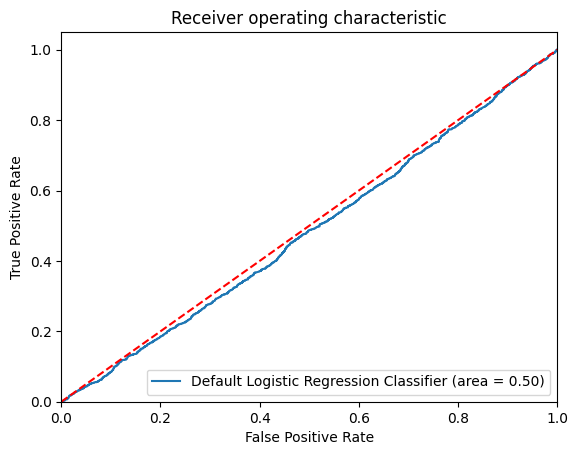

In [11]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()
logReg.fit(X_train, y_train)
logReg_ypred = logReg.predict(X_test)

print('Accuracy of Default Logistic Regression Classifier on train set: {:.2f}'.format(logReg.score(X_train, y_train)))
print('Accuracy of Default Logistic Regression Classifier on test set: {:.2f}'.format(logReg.score(X_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, logReg_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)

logReg_roc_auc = roc_auc_score(y_test, logReg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logReg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Default Logistic Regression Classifier (area = %0.2f)' % logReg_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Rather low accuracy. Almost the same as guessing an option with 50% chance.

Diving deeper into the confusion matrix, there is no true negative or false negative and only true positive and false positive. Hence, this confirms our suspicion that the model merely predicts positive for all the points with no learning.

Not much point trying to tune parameters (solver, regularization)

### Weighted Logistic Regression

In [12]:
wt = {0:0.51, 1:0.49}
logReg2 = LogisticRegression(class_weight = wt)
logReg2.fit(X_train, y_train)
logReg2_ypred = logReg2.predict(X_test)

print('Accuracy of Weighted Logistic Regression Classifier on train set: {:.2f}'.format(logReg2.score(X_train, y_train)))
print('Accuracy of Weighted Logistic Regression Classifier on test set: {:.2f}'.format(logReg2.score(X_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, logReg2_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)
print('Precision of Weighted Logistic Regression Classifier on test set: {:.2f}'.format(precision_score(y_test, logReg2_ypred)))
print('Recall of Weighted Logistic Regression Classifier on test set: {:.2f}'.format(recall_score(y_test, logReg2_ypred)))


Accuracy of Weighted Logistic Regression Classifier on train set: 0.51
Accuracy of Weighted Logistic Regression Classifier on test set: 0.52
Confusion Matrix:
True Neg: 0 	 False Pos: 3520
False Neg: 0 	 True Pos: 3771
Precision of Weighted Logistic Regression Classifier on test set: 0.52
Recall of Weighted Logistic Regression Classifier on test set: 1.00


Changing weights does not help. The model will predict all of the points to the class with a higher weights (ie. all predict class 0 now that class 0 has a larger weight)

### Feature Selection Logistic Regression

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'AGE',
       'EMPLOYED', 'YEARS_EMPLOYED', 'EDUCATION', 'WAY_OF_LIVING'],
      dtype='object')
Accuracy of RFE Logistic Regression on train set: 0.51
Accuracy of RFE Logistic Regression on test set: 0.52
Confusion Matrix:
True Neg: 0 	 False Pos: 3520
False Neg: 0 	 True Pos: 3771


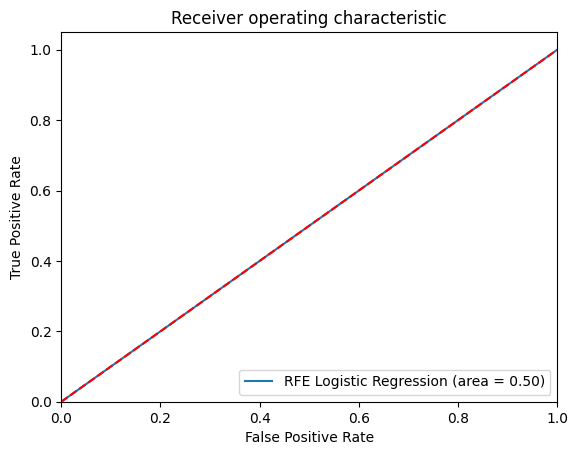

In [13]:
from sklearn.feature_selection import RFE
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=8)
rfe.fit(X_train, y_train)
rfe_ypred = rfe.predict(X_test)

print(X_train.columns[rfe.support_])
print('Accuracy of RFE Logistic Regression on train set: {:.2f}'.format(rfe.score(X_train, y_train)))
print('Accuracy of RFE Logistic Regression on test set: {:.2f}'.format(rfe.score(X_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, rfe_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)

rfe_roc_auc = roc_auc_score(y_test, rfe.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfe.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='RFE Logistic Regression (area = %0.2f)' % rfe_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Ridge Classifier

Accuracy of Default Ridge Regression Classifier on train set: 0.51
Accuracy of Default Ridge Regression Classifier on test set: 0.51
Confusion Matrix:
True Neg: 962 	 False Pos: 2558
False Neg: 979 	 True Pos: 2792


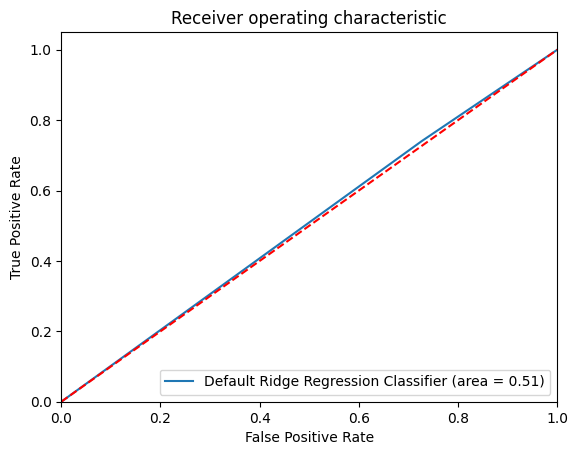

In [14]:
from sklearn.linear_model import RidgeClassifier

ridgeClass = RidgeClassifier()
ridgeClass.fit(X_train, y_train)
ridgeClass_ypred = ridgeClass.predict(X_test)

print('Accuracy of Default Ridge Regression Classifier on train set: {:.2f}'.format(ridgeClass.score(X_train, y_train)))
print('Accuracy of Default Ridge Regression Classifier on test set: {:.2f}'.format(ridgeClass.score(X_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, ridgeClass_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)

ridgeClass_roc_auc = roc_auc_score(y_test, ridgeClass.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, ridgeClass.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Default Ridge Regression Classifier (area = %0.2f)' % ridgeClass_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()



---

##Decision Tree/Random Forest

Accuracy of Default Decision Tree Classifier on train set: 0.80
Accuracy of Default Decision Tree Classifier on test set: 0.65
Confusion Matrix:
True Neg: 2375 	 False Pos: 1145
False Neg: 1423 	 True Pos: 2348
Precision of Default Decision Tree Classifier on test set: 0.67
Recall of Default Decision Tree Classifier on test set: 0.62


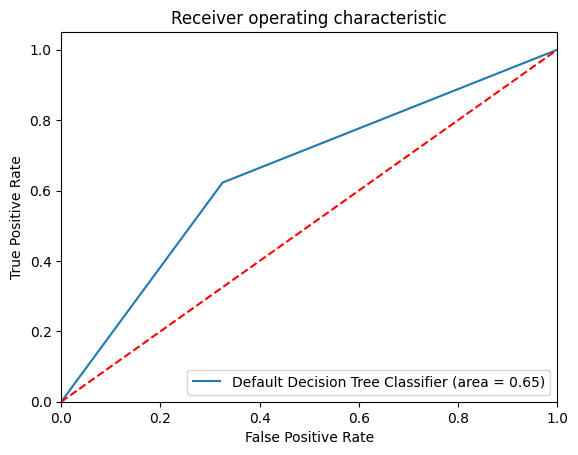

In [16]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
tree_ypred = tree.predict(X_test)



print('Accuracy of Default Decision Tree Classifier on train set: {:.2f}'.format(tree.score(X_train, y_train)))
print('Accuracy of Default Decision Tree Classifier on test set: {:.2f}'.format(tree.score(X_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, tree_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)
print('Precision of Default Decision Tree Classifier on test set: {:.2f}'.format(precision_score(y_test, tree_ypred)))
print('Recall of Default Decision Tree Classifier on test set: {:.2f}'.format(recall_score(y_test, tree_ypred)))

tree_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tree.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Default Decision Tree Classifier (area = %0.2f)' % tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

More hopeful than logisitic regression. Model is clearly overfitted with accuracy of 1.00 on training dataset and 0.63 for test. We can explore some parameter tuning to make some changes to the model.

Higher proportion of true negatives (2139) and true positives (2464). False negatives (1326) and false positives (1363) are about the same.


We can also use some domain knowledge in setting our threshold. For a credit card approval model, it may be better for us to be more conservative in order to minimise the large amount of monetary loss due to bad credit behaviour. Remember that in our model, 1 represents good credit (approval) and 0 represents bad credit (reject). Thus, false negatives are records with good credit which we have rejected while false positives are records with bad credit which we have approved and we should aim to lower the number of false positives. Hence in this case, we can set a tighter threshold to lead to our model predicting fewer credit card application approvals in order to lead to a lower false positive rate.



---

###Decision Tree: Max_depth

Tree depth:  36
Accuracy of Decision Tree Classifier with max depth = 4 on train set: 0.53
Accuracy of Decision Tree Classifier with max depth = 4 on test set: 0.54


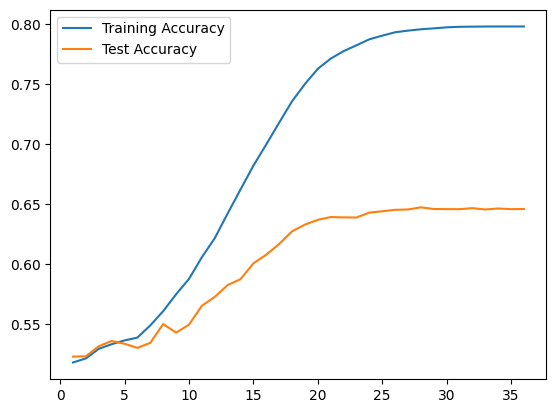

In [17]:
# Hyperparameter tuning with decision tree: max_depth
print('Tree depth: ', tree.tree_.max_depth)
tree2 = DecisionTreeClassifier(max_depth = 4)
tree2.fit(X_train,y_train)
tree2_ypred = tree.predict(X_test)

print('Accuracy of Decision Tree Classifier with max depth = 4 on train set: {:.2f}'.format(tree2.score(X_train, y_train)))
print('Accuracy of Decision Tree Classifier with max depth = 4 on test set: {:.2f}'.format(tree2.score(X_test, y_test)))

tree2_trainaccuracy = np.zeros(shape=(tree.tree_.max_depth))
tree2_testaccuracy = np.zeros(shape=(tree.tree_.max_depth))
for max_d in range(1,tree.tree_.max_depth+1):
  tree2 = DecisionTreeClassifier(max_depth=max_d, random_state=42)
  tree2.fit(X_train,y_train)
  tree2_trainaccuracy[max_d - 1]= tree2.score(X_train, y_train)
  tree2_testaccuracy[max_d - 1]= tree2.score(X_test, y_test)

depths = range(1, tree.tree_.max_depth+1)

# Plot and label the training and validation loss values
plt.plot(depths, tree2_trainaccuracy, label='Training Accuracy')
plt.plot(depths, tree2_testaccuracy, label='Test Accuracy')
plt.legend(loc='best')
plt.show()

Model starts overfitting around depth of 10 onwards but model performance prior is also not great with test accuracy about 0.55.

Note that in our decision tree model, we face the issue of low bias and high variance instead of high bias, low variance. Hence, we should be employing bagging instead of boosting and we will try building a random forest classifier next.

### Feature Selection with Decision Tree

Index(['AMT_INCOME_TOTAL', 'AGE', 'YEARS_EMPLOYED'], dtype='object')
Accuracy of Feature Selected Decision Tree Classifier on train set: 0.78
Accuracy of Feature Selected Decision Tree Classifier on test set: 0.64
Confusion Matrix:
True Neg: 2332 	 False Pos: 1188
False Neg: 1462 	 True Pos: 2309
Precision of Feature Selected Decision Tree Classifier on test set: 0.66
Recall of Feature Selected Decision Tree Classifier on test set: 0.61


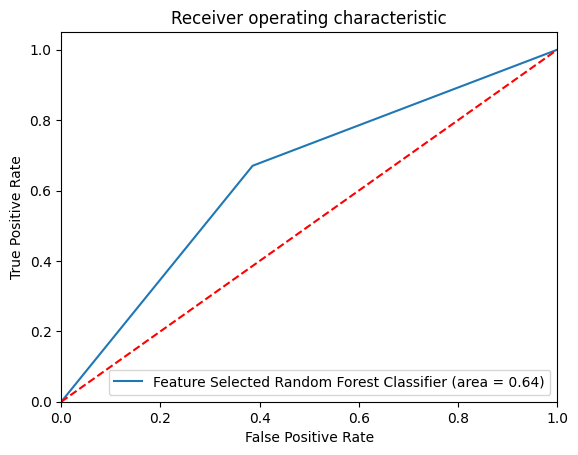

In [ ]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(DecisionTreeClassifier())
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

newX_train = X_train[selected_feat]
newX_test = X_test[selected_feat]

dt_feat = DecisionTreeClassifier()
dt_feat.fit(newX_train, y_train)
dt_feat_ypred = dt_feat.predict(newX_test)

print('Accuracy of Feature Selected Decision Tree Classifier on train set: {:.2f}'.format(dt_feat.score(newX_train, y_train)))
print('Accuracy of Feature Selected Decision Tree Classifier on test set: {:.2f}'.format(dt_feat.score(newX_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, dt_feat_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)
print('Precision of Feature Selected Decision Tree Classifier on test set: {:.2f}'.format(precision_score(y_test, dt_feat_ypred)))
print('Recall of Feature Selected Decision Tree Classifier on test set: {:.2f}'.format(recall_score(y_test, dt_feat_ypred)))

rf_feat_roc_auc = roc_auc_score(y_test, rf_feat.predict(newX_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_feat.predict(newX_test))
plt.figure()
plt.plot(fpr, tpr, label='Feature Selected Random Forest Classifier (area = %0.2f)' % rf_feat_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Accuracy of Feature Selected Decision Tree Classifier on train set: 0.78
Accuracy of Feature Selected Decision Tree Classifier on test set: 0.64
Confusion Matrix:
True Neg: 2329 	 False Pos: 1191
False Neg: 1460 	 True Pos: 2311
Precision of Feature Selected Decision Tree Classifier on test set: 0.66
Recall of Feature Selected Decision Tree Classifier on test set: 0.61


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


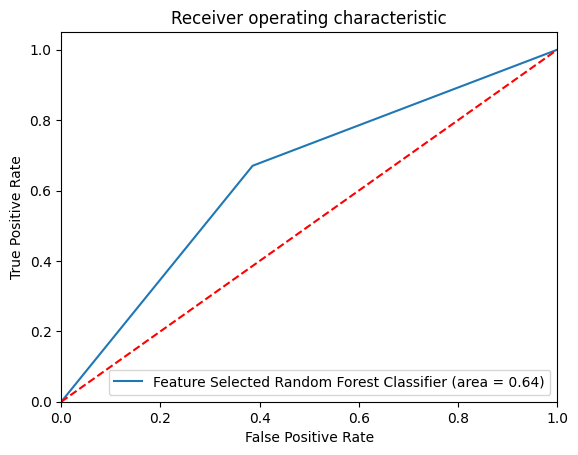

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
model = SelectFromModel(clf, prefit=True)
newX_train = model.transform(X_train)
newX_test = model.transform(X_test)

dt_feat = DecisionTreeClassifier()
dt_feat.fit(newX_train, y_train)
dt_feat_ypred = dt_feat.predict(newX_test)

print('Accuracy of Feature Selected Decision Tree Classifier on train set: {:.2f}'.format(dt_feat.score(newX_train, y_train)))
print('Accuracy of Feature Selected Decision Tree Classifier on test set: {:.2f}'.format(dt_feat.score(newX_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, dt_feat_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)
print('Precision of Feature Selected Decision Tree Classifier on test set: {:.2f}'.format(precision_score(y_test, dt_feat_ypred)))
print('Recall of Feature Selected Decision Tree Classifier on test set: {:.2f}'.format(recall_score(y_test, dt_feat_ypred)))

rf_feat_roc_auc = roc_auc_score(y_test, rf_feat.predict(newX_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_feat.predict(newX_test))
plt.figure()
plt.plot(fpr, tpr, label='Feature Selected Random Forest Classifier (area = %0.2f)' % rf_feat_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()



---



##Random Forest

Accuracy of Default Random Forest Classifier on train set: 0.80
Accuracy of Default Random Forest Classifier on test set: 0.65
Confusion Matrix:
True Neg: 2199 	 False Pos: 1321
False Neg: 1206 	 True Pos: 2565
Precision of Default Random Forest Classifier on test set: 0.66
Recall of Default Random Forest Classifier on test set: 0.68


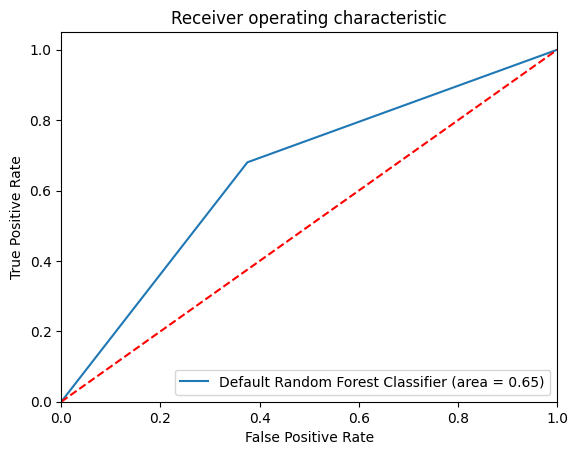

In [18]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train,y_train)
forest_ypred = forest.predict(X_test)

print('Accuracy of Default Random Forest Classifier on train set: {:.2f}'.format(forest.score(X_train, y_train)))
print('Accuracy of Default Random Forest Classifier on test set: {:.2f}'.format(forest.score(X_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, forest_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)
print('Precision of Default Random Forest Classifier on test set: {:.2f}'.format(precision_score(y_test, forest_ypred)))
print('Recall of Default Random Forest Classifier on test set: {:.2f}'.format(recall_score(y_test, forest_ypred)))

forest_roc_auc = roc_auc_score(y_test, forest.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, forest.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Default Random Forest Classifier (area = %0.2f)' % forest_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Similar performance to a single decision tree

Higher proportion of true negatives (2165) and true positives (2450). False negatives (1340) and false positives (1337) are about the same.

Random forests typically are only able to better perform a single decision tree when we tune their hyperparameters. We can now attempt to tune the model and see if it gives us better results instead.

Accuracy of CV Grid Search Random Forest Classifier on train set: 0.55
Accuracy of CV Grid Search Random Forest Classifier on test set: 0.54
Confusion Matrix:
True Neg: 1399 	 False Pos: 2121
False Neg: 1252 	 True Pos: 2519
Precision of CV Grid Search Random Forest Classifier on test set: 0.54
Recall of CV Grid Search Random Forest Classifier on test set: 0.67


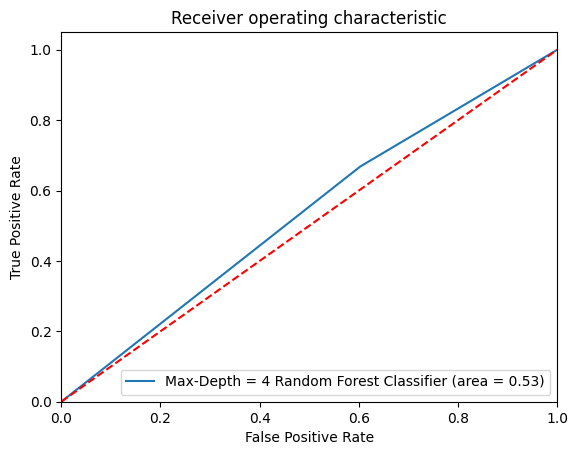

In [ ]:
# max_depth = sqrt(d) = 4
rf_4depth = RandomForestClassifier(max_depth=4,
                                    max_features=None,
                                    n_estimators=200)
rf_4depth.fit(X_train, y_train)
rf_4depth_ypred = rf_4depth.predict(X_test)

print('Accuracy of CV Grid Search Random Forest Classifier on train set: {:.2f}'.format(rf_4depth.score(X_train, y_train)))
print('Accuracy of CV Grid Search Random Forest Classifier on test set: {:.2f}'.format(rf_4depth.score(X_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, rf_4depth_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)
print('Precision of CV Grid Search Random Forest Classifier on test set: {:.2f}'.format(precision_score(y_test, rf_4depth_ypred)))
print('Recall of CV Grid Search Random Forest Classifier on test set: {:.2f}'.format(recall_score(y_test, rf_4depth_ypred)))

rf_4depth_roc_auc = roc_auc_score(y_test, rf_4depth.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_4depth.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Max-Depth = 4 Random Forest Classifier (area = %0.2f)' % rf_4depth_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

----

###Random Forest: Grid Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


param_grid = {
    'n_estimators': [10, 100, 200],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth' : [3,6,9],
    'criterion' :['gini', 'entropy']
}

In [ ]:
# gridsearch

grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_features=None, n_estimators=200)


Accuracy of CV Grid Search Random Forest Classifier on train set: 0.72
Accuracy of CV Grid Search Random Forest Classifier on test set: 0.61
Confusion Matrix:
True Neg: 1795 	 False Pos: 1707
False Neg: 1123 	 True Pos: 2667
Precision of CV Grid Search Random Forest Classifier on test set: 0.61
Recall of CV Grid Search Random Forest Classifier on test set: 0.70


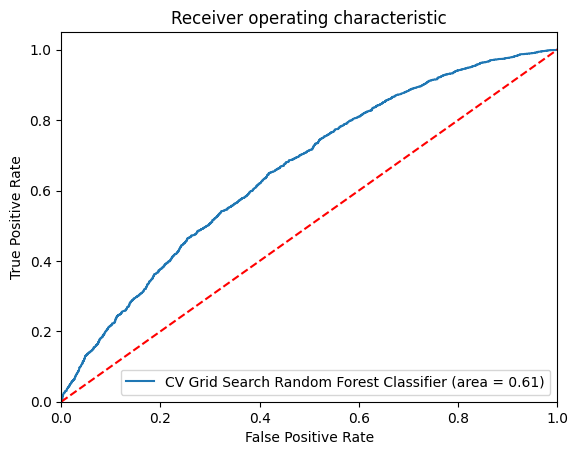

In [ ]:
rf_grid = RandomForestClassifier(max_depth=9,
                                    max_features=None,
                                    n_estimators=200)
rf_grid.fit(X_train, y_train)
grid_ypred = rf_grid.predict(X_test)

print('Accuracy of CV Grid Search Random Forest Classifier on train set: {:.2f}'.format(rf_grid.score(X_train, y_train)))
print('Accuracy of CV Grid Search Random Forest Classifier on test set: {:.2f}'.format(rf_grid.score(X_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, grid_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)
print('Precision of CV Grid Search Random Forest Classifier on test set: {:.2f}'.format(precision_score(y_test, grid_ypred)))
print('Recall of CV Grid Search Random Forest Classifier on test set: {:.2f}'.format(recall_score(y_test, grid_ypred)))

forest_roc_auc = roc_auc_score(y_test, rf_grid.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_grid.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='CV Grid Search Random Forest Classifier (area = %0.2f)' % forest_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Precision decreased while recall increased but we want to reduce false positives (so should increase precision instead!)

### Random Forest: Random Search CV

In [ ]:
#random search

random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   param_grid)
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_features='log2', n_estimators=200)


Accuracy of CV Random Search Random Forest Classifier on train set: 0.69
Accuracy of CV Random Search Random Forest Classifier on test set: 0.60
Confusion Matrix:
True Neg: 1766 	 False Pos: 1736
False Neg: 1154 	 True Pos: 2636
Precision of CV Random Search Random Forest Classifier on test set: 0.60
Recall of CV Random Search Random Forest Classifier on test set: 0.70


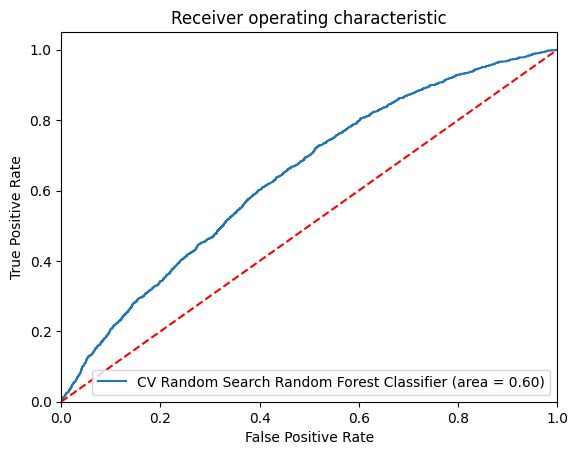

In [ ]:
rf_random = RandomForestClassifier(max_depth=9,
                                      max_features='log2',
                                      n_estimators=200)
rf_random.fit(X_train, y_train)
rand_ypred = rf_random.predict(X_test)

print('Accuracy of CV Random Search Random Forest Classifier on train set: {:.2f}'.format(rf_random.score(X_train, y_train)))
print('Accuracy of CV Random Search Random Forest Classifier on test set: {:.2f}'.format(rf_random.score(X_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, rand_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)
print('Precision of CV Random Search Random Forest Classifier on test set: {:.2f}'.format(precision_score(y_test, rand_ypred)))
print('Recall of CV Random Search Random Forest Classifier on test set: {:.2f}'.format(recall_score(y_test, rand_ypred)))

forest_roc_auc = roc_auc_score(y_test, rf_random.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_random.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='CV Random Search Random Forest Classifier (area = %0.2f)' % forest_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Feature Selection with Random Forest

Index(['AMT_INCOME_TOTAL', 'AGE', 'YEARS_EMPLOYED'], dtype='object')
Accuracy of Feature Selected Random Forest Classifier on train set: 0.78
Accuracy of Feature Selected Random Forest Classifier on test set: 0.64
Confusion Matrix:
True Neg: 2162 	 False Pos: 1358
False Neg: 1243 	 True Pos: 2528
Precision of Feature Selected Random Forest Classifier on test set: 0.65
Recall of Feature Selected Random Forest Classifier on test set: 0.67


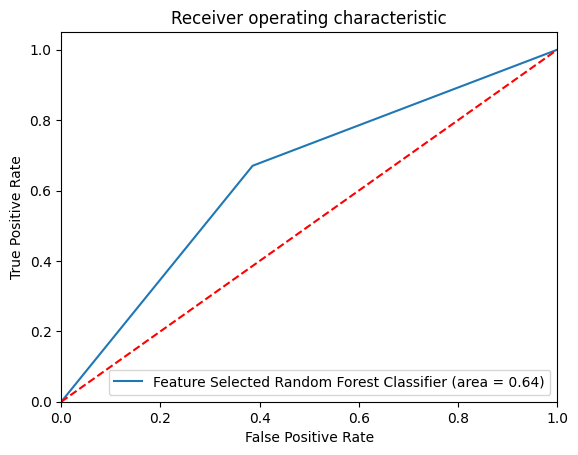

In [ ]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

newX_train = X_train[selected_feat]
newX_test = X_test[selected_feat]

rf_feat = RandomForestClassifier()
rf_feat.fit(newX_train, y_train)
rf_feat_ypred = rf_feat.predict(newX_test)

print('Accuracy of Feature Selected Random Forest Classifier on train set: {:.2f}'.format(rf_feat.score(newX_train, y_train)))
print('Accuracy of Feature Selected Random Forest Classifier on test set: {:.2f}'.format(rf_feat.score(newX_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, rf_feat_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)
print('Precision of Feature Selected Random Forest Classifier on test set: {:.2f}'.format(precision_score(y_test, rf_feat_ypred)))
print('Recall of Feature Selected Random Forest Classifier on test set: {:.2f}'.format(recall_score(y_test, rf_feat_ypred)))

rf_feat_roc_auc = roc_auc_score(y_test, rf_feat.predict(newX_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_feat.predict(newX_test))
plt.figure()
plt.plot(fpr, tpr, label='Feature Selected Random Forest Classifier (area = %0.2f)' % rf_feat_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
param_grid = {
    'n_estimators': [10, 100, 200],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth' : [3,6, 9],
    'criterion' :['gini', 'entropy']
}

grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(newX_train, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_features=None, n_estimators=200)


Accuracy of CV Grid Search Random Forest Classifier on train set: 0.65
Accuracy of CV Grid Search Random Forest Classifier on test set: 0.59
Confusion Matrix:
True Neg: 1734 	 False Pos: 1786
False Neg: 1208 	 True Pos: 2563
Precision of CV Grid Search Random Forest Classifier on test set: 0.59
Recall of CV Grid Search Random Forest Classifier on test set: 0.68


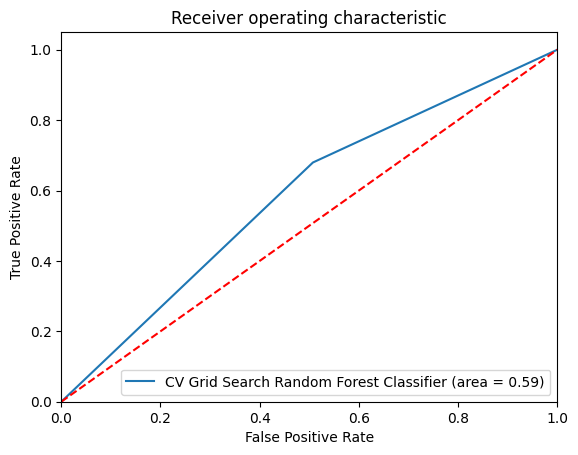

In [ ]:
rf_grid = RandomForestClassifier(max_depth=9,
                                    max_features=None,
                                    n_estimators=200)
rf_grid.fit(newX_train, y_train)
grid_ypred = rf_grid.predict(newX_test)

print('Accuracy of CV Grid Search Random Forest Classifier on train set: {:.2f}'.format(rf_grid.score(newX_train, y_train)))
print('Accuracy of CV Grid Search Random Forest Classifier on test set: {:.2f}'.format(rf_grid.score(newX_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, grid_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)
print('Precision of CV Grid Search Random Forest Classifier on test set: {:.2f}'.format(precision_score(y_test, grid_ypred)))
print('Recall of CV Grid Search Random Forest Classifier on test set: {:.2f}'.format(recall_score(y_test, grid_ypred)))

forest_roc_auc = roc_auc_score(y_test, rf_grid.predict(newX_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_grid.predict(newX_test))
plt.figure()
plt.plot(fpr, tpr, label='CV Grid Search Random Forest Classifier (area = %0.2f)' % forest_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

---

##PCA / LDA / QDA / PLS

### PCA: Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_test)
pca_explained_variance = pca.explained_variance_ratio_

print(pca_explained_variance)

[9.99999897e-01 7.58121704e-08 2.41435854e-08 6.92912055e-10
 6.43644021e-10 3.87453424e-10 1.65520974e-10 1.51806337e-10
 1.15215194e-10 1.12589797e-10 1.04390469e-10 8.14603511e-11
 6.47543384e-11 4.50065684e-11 3.16413742e-11 3.79488358e-13
 2.47067391e-13 1.14973987e-42]


First principal component already explains all the variance.

In [ ]:
model_pca = PCA(n_components=2)
model_pca_X_train = model_pca.fit_transform(X_train)
model_pca_X_test = model_pca.transform(X_test)

Accuracy of logistic regression classifier on train set: 0.51
Accuracy of logistic regression classifier on test set: 0.51
Confusion Matrix:
True Neg: 1800 	 False Pos: 1702
False Neg: 1883 	 True Pos: 1907


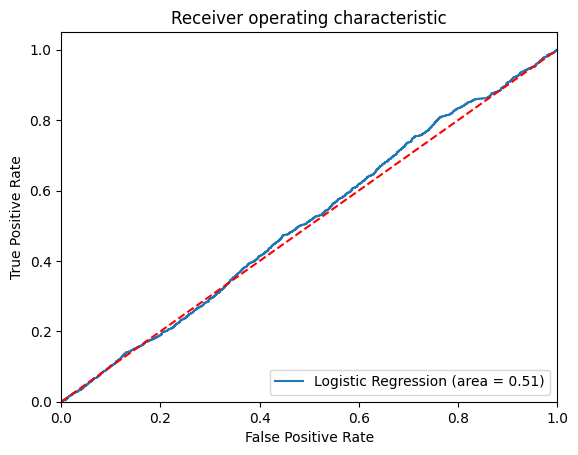

In [ ]:
pca_logReg = LogisticRegression()
pca_logReg.fit(model_pca_X_train, y_train)
pca_logReg_ypred = pca_logReg.predict(model_pca_X_test)

print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(pca_logReg.score(model_pca_X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(pca_logReg.score(model_pca_X_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, pca_logReg_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)

pca_logReg_roc_auc = roc_auc_score(y_test, pca_logReg.predict(model_pca_X_test))
fpr, tpr, thresholds = roc_curve(y_test, pca_logReg.predict_proba(model_pca_X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % pca_logReg_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Accuracy of default decision tree classifier on train set: 0.53
Accuracy of default decision tree classifier on test set: 0.52
Confusion Matrix:
True Neg: 1237 	 False Pos: 2265
False Neg: 1216 	 True Pos: 2574
Precision of PCA classifier on test set: 0.53
Recall of PCA classifier on test set: 0.68


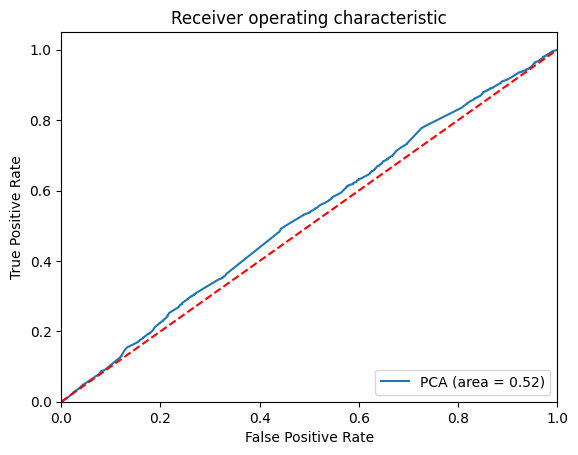

In [ ]:
pca_tree = RandomForestClassifier(max_depth=2, random_state=0)
pca_tree.fit(model_pca_X_train, y_train)
pca_tree_ypred = pca_tree.predict(model_pca_X_test)


print('Accuracy of default decision tree classifier on train set: {:.2f}'.format(pca_tree.score(model_pca_X_train, y_train)))
print('Accuracy of default decision tree classifier on test set: {:.2f}'.format(pca_tree.score(model_pca_X_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, pca_tree_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)
print('Precision of PCA classifier on test set: {:.2f}'.format(precision_score(y_test, pca_tree_ypred)))
print('Recall of PCA classifier on test set: {:.2f}'.format(recall_score(y_test, pca_tree_ypred)))

pca_tree_roc_auc = roc_auc_score(y_test, pca_tree.predict(model_pca_X_test))
fpr, tpr, thresholds = roc_curve(y_test, pca_tree.predict(model_pca_X_test))
plt.figure()
plt.plot(fpr, tpr, label='PCA (area = %0.2f)' % pca_tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### LDA: Linear Discriminant Analysis

0.5160180282747228
Accuracy of default LDA classifier on train set: 0.52
Accuracy of default LDA classifier on test set: 0.51
Confusion Matrix:
True Neg: 1148 	 False Pos: 2354
False Neg: 1193 	 True Pos: 2597
Precision of default LDA classifier on test set: 0.52
Recall of default LDA classifier on test set: 0.69


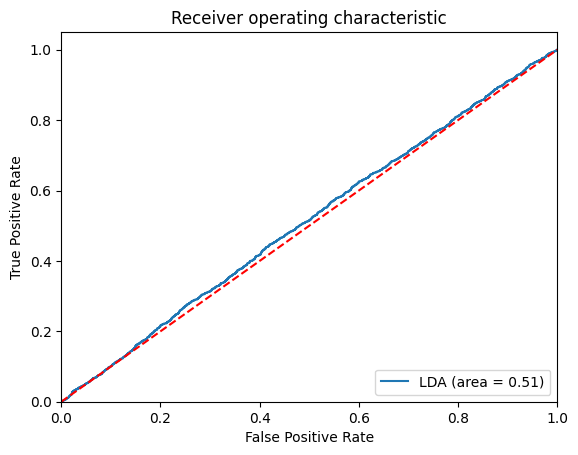

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda_ypred = lda.predict(X_test)

lda_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
lda_scores = cross_val_score(lda, X_train, y_train, scoring='accuracy', cv=lda_cv, n_jobs=-1)
print(np.mean(lda_scores))

print('Accuracy of default LDA classifier on train set: {:.2f}'.format(lda.score(X_train, y_train)))
print('Accuracy of default LDA classifier on test set: {:.2f}'.format(lda.score(X_test, y_test)))

tn, fp, fn, tp = confusion_matrix(y_test, lda_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)
print('Precision of default LDA classifier on test set: {:.2f}'.format(precision_score(y_test, lda_ypred)))
print('Recall of default LDA classifier on test set: {:.2f}'.format(recall_score(y_test, lda_ypred)))

lda_roc_auc = roc_auc_score(y_test, lda.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lda.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='LDA (area = %0.2f)' % lda_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### PLS: Partial Least Squares

supervised learning
use a modified version of PLS: PLS-DA (Partial Least Squares Discriminant Analysis) to classify

In [ ]:
from sklearn.cross_decomposition import PLSRegression
pls_binary = PLSRegression(n_components=2)
pls_binary.fit(X_train, y_train)

pls_ypred_raw = pls_binary.predict(X_test)[:,0]
pls_ypred = (pls_binary.predict(X_test)[:,0] > 0.5).astype('uint8')

print('Precision of PLS-DA classifier on test set: {:.2f}'.format(accuracy_score(y_test, rand_ypred)))
print('Precision of PLS-DA classifier on test set: {:.2f}'.format(precision_score(y_test, rand_ypred)))
print('Recall of PLS-DA classifier on test set: {:.2f}'.format(recall_score(y_test, rand_ypred)))

Precision of PLS-DA classifier on test set: 0.61
Precision of PLS-DA classifier on test set: 0.60
Recall of PLS-DA classifier on test set: 0.70


## Boosting and Ensemble Methods

In [19]:
#Evaluating Metrics
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Function to evaluate the model and print metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Print accuracy
    print('Accuracy on test set: {:.8f}'.format(accuracy_score(y_test, y_pred)))

    # Print confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Confusion Matrix:')
    print('True Neg:', tn, '\t' ,'False Pos:', fp)
    print('False Neg:', fn, '\t', 'True Pos:', tp)

    # Print precision and recall
    print('Precision on test set: {:.8f}'.format(precision_score(y_test, y_pred)))
    print('Recall on test set: {:.8f}'.format(recall_score(y_test, y_pred)))

    # Plot ROC Curve
    try:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

        plt.figure()
        plt.plot(fpr, tpr, label='Model (area = %0.5f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    except AttributeError:
        print("Model does not have predict_proba method. ROC curve not plotted.")


### XGBoost


Accuracy of xgboost classifier on train set: 0.74
Accuracy of xgboost classifier on test set: 0.63
Confusion Matrix:
True Neg: 2065 	 False Pos: 1455
False Neg: 1241 	 True Pos: 2530
Precision of xgboost classifier on test set: 0.63
Recall of xgboost classifier on test set: 0.67


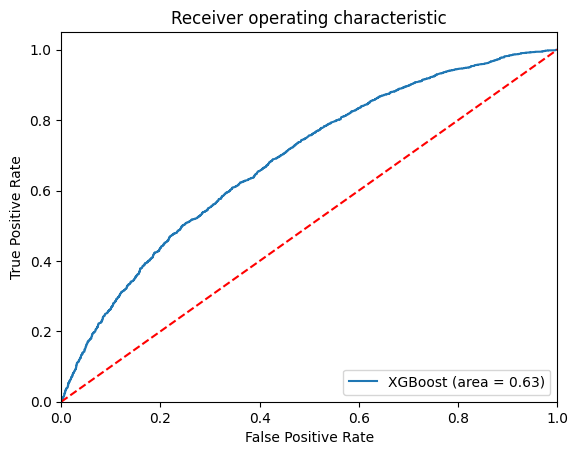

In [ ]:
#XGBoost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=len(set(y)))
#xgb_model = XGBClassifier(learning_rate=0.005, n_estimators=3000)

# Train the model
xgb_model.fit(X_train, y_train)
xgb_model
# Make predictions on the test set
xgb_ypred = xgb_model.predict(X_test)

print('Accuracy of xgboost classifier on train set: {:.2f}'.format(accuracy_score(y_train, xgb_model.predict(X_train))))
print('Accuracy of xgboost classifier on test set: {:.2f}'.format(accuracy_score(y_test, xgb_ypred)))

tn, fp, fn, tp = confusion_matrix(y_test, xgb_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)

print('Precision of xgboost classifier on test set: {:.2f}'.format(precision_score(y_test, xgb_ypred)))
print('Recall of xgboost classifier on test set: {:.2f}'.format(recall_score(y_test, xgb_ypred)))

xgboost_roc_auc = roc_auc_score(y_test, xgb_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % xgboost_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
#lr 0.005 n_est 3000 ~ 0.62
#softmax ~ 0.63

### Catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.6 MB/s eta 0:00:00
0:	learn: 0.6920699	total: 82.1ms	remaining: 41s
1:	learn: 0.6909091	total: 114ms	remaining: 28.4s
2:	learn: 0.6896148	total: 145ms	remaining: 24s
3:	learn: 0.6886950	total: 176ms	remaining: 21.8s
4:	learn: 0.6877930	total: 205ms	remaining: 20.3s
5:	learn: 0.6870235	total: 234ms	remaining: 19.3s
6:	learn: 0.6854183	total: 266ms	remaining: 18.7s
7:	learn: 0.6845524	total: 299ms	remaining: 18.4s
8:	learn: 0.6831996	total: 329ms	remaining: 17.9s
9:	learn: 0.6824104	total: 358ms	remaining: 17.5s
10:	learn: 0.6814611	total: 387ms	remaining: 17.2s
11:	learn: 0.6804911	total: 416ms	remaining: 16.9s
12:	learn: 0.6795559	total: 445ms	remaining: 16.7s
13:	learn: 0.6782020	total: 478ms	remaining: 16.6s
14:	learn: 0.6774548	total: 510ms	remaining: 16.5s
15:	learn: 0.6766488	total: 541ms	remaining: 16.4s
16:	learn: 0.6762818	total: 583ms	remaining: 16.6s
17:	learn: 0.6754744	total: 615ms	remaining: 16.5s
18:	learn: 0.67

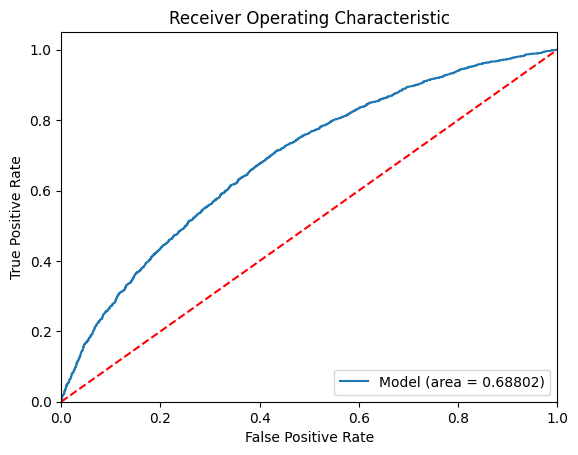

In [22]:
#Catboost
!pip install catboost

import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create and train the CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=10, loss_function='Logloss')
catboost_model.fit(X_train, y_train)
evaluate_model(catboost_model, X_train, y_train, X_test, y_test)



### LGB

[LightGBM] [Info] Number of positive: 14933, number of negative: 14227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512106 -> initscore=0.048432
[LightGBM] [Info] Start training from score 0.048432
[LightGBM] [Info] Number of positive: 14933, number of negative: 14227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 15
[LightGBM] [Info] [bin

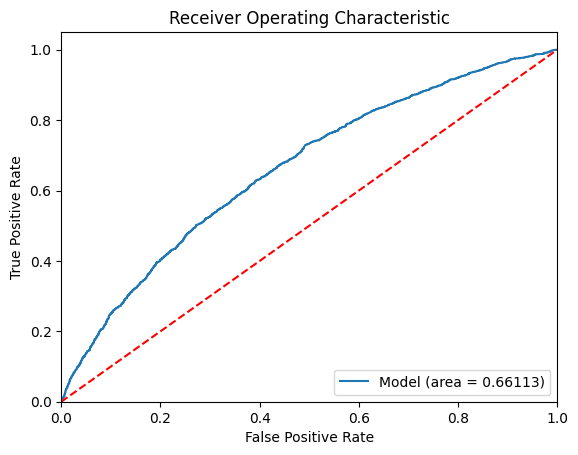

In [21]:
#LGB
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create and train the LightGBM classifier
lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=500)
lgb_model.fit(X_train, y_train)

evaluate_model(lgb_model, X_train, y_train, X_test, y_test)


### Ensemble

0:	learn: 0.6915036	total: 32.3ms	remaining: 16.1s
1:	learn: 0.6903569	total: 64.3ms	remaining: 16s
2:	learn: 0.6886457	total: 98.7ms	remaining: 16.4s
3:	learn: 0.6885466	total: 104ms	remaining: 12.9s
4:	learn: 0.6866242	total: 134ms	remaining: 13.3s
5:	learn: 0.6849034	total: 165ms	remaining: 13.6s
6:	learn: 0.6835713	total: 199ms	remaining: 14s
7:	learn: 0.6820162	total: 233ms	remaining: 14.3s
8:	learn: 0.6808239	total: 264ms	remaining: 14.4s
9:	learn: 0.6801670	total: 293ms	remaining: 14.4s
10:	learn: 0.6790928	total: 324ms	remaining: 14.4s
11:	learn: 0.6781006	total: 355ms	remaining: 14.4s
12:	learn: 0.6762409	total: 387ms	remaining: 14.5s
13:	learn: 0.6754988	total: 417ms	remaining: 14.5s
14:	learn: 0.6741712	total: 451ms	remaining: 14.6s
15:	learn: 0.6724606	total: 483ms	remaining: 14.6s
16:	learn: 0.6719672	total: 513ms	remaining: 14.6s
17:	learn: 0.6709301	total: 546ms	remaining: 14.6s
18:	learn: 0.6703119	total: 577ms	remaining: 14.6s
19:	learn: 0.6692284	total: 611ms	remainin

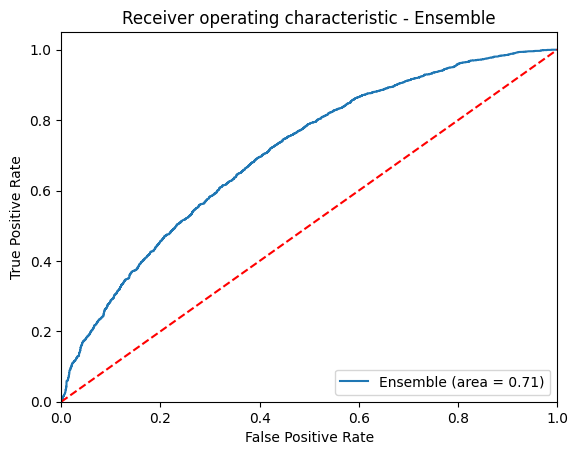

In [ ]:
#XGB Catboost RF LGB Ensemble
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create individual models
xgb_model = XGBClassifier(learning_rate=0.05, n_estimators=500)
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=10, loss_function='Logloss')
rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=500)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('catboost', catboost_model),
    ('rf', rf_model),
    ('lgb', lgb_model)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions on the test set
ensemble_ypred = ensemble_model.predict(X_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, ensemble_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)

# Precision and Recall
print('Precision of Ensemble classifier on test set: {:.2f}'.format(precision_score(y_test, ensemble_ypred)))
print('Recall of Ensemble classifier on test set: {:.2f}'.format(recall_score(y_test, ensemble_ypred)))

# Accuracy
accuracy = accuracy_score(y_test, ensemble_ypred)
print(f"Ensemble Accuracy: {accuracy}")


# ROC Curve
try:
    # Use predict_proba if available
    ensemble_roc_auc = roc_auc_score(y_test, ensemble_model.predict_proba(X_test)[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test, ensemble_model.predict_proba(X_test)[:, 1])
except AttributeError:
    # Use decision_function for models that don't have predict_proba
    ensemble_roc_auc = roc_auc_score(y_test, ensemble_model.decision_function(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, ensemble_model.decision_function(X_test))

plt.figure()
plt.plot(fpr, tpr, label='Ensemble (area = %0.2f)' % ensemble_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Ensemble')
plt.legend(loc="lower right")
plt.savefig('Ensemble_ROC')
plt.show()

### XGBoost Ensemble

In [ ]:
#XGBoost Ensemble
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create individual XGBoost models with different hyperparameters
xgb_model_1 = XGBClassifier(learning_rate=0.1, n_estimators=1000)
xgb_model_2 = XGBClassifier(learning_rate=0.05, n_estimators=2000)
xgb_model_3 = XGBClassifier(learning_rate=0.01, n_estimators=3000)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('xgb_1', xgb_model_1),
    ('xgb_2', xgb_model_2),
    ('xgb_3', xgb_model_3)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ensemble_model.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {accuracy}")
#0.1/0.05/0.01 learning rate, 500/1000/1500 estimators 0.6385079539221065
#0.1/0.05/0.01 learning rate, 1000/2000/3000 estimators0.6464618760285245

Ensemble Accuracy: 0.6464618760285245


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Confusion Matrix:
True Neg: 1721 	 False Pos: 1799
False Neg: 1320 	 True Pos: 2451
Precision of Adaboost classifier on test set: 0.58
Recall of Adaboost classifier on test set: 0.65
Adaboost Accuracy: 0.5722123165546564


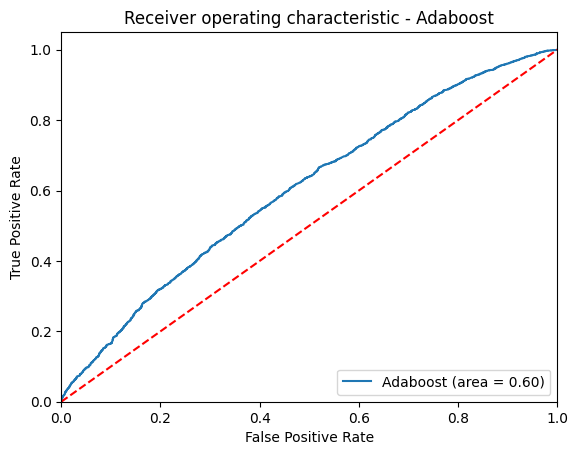

In [ ]:
#ADABoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a base decision tree model
base_model = DecisionTreeClassifier(max_depth=3)

# Create an Adaboost model with the base decision tree
adaboost_model = AdaBoostClassifier(base_estimator=base_model,
                                    n_estimators=50,  # Number of boosting rounds
                                    random_state=42)

# Train the Adaboost model
adaboost_model.fit(X_train, y_train)

# Make predictions on the test set
adaboost_ypred = adaboost_model.predict(X_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, adaboost_ypred).ravel()
print('Confusion Matrix:')
print('True Neg:', tn, '\t' ,'False Pos:', fp)
print('False Neg:', fn, '\t', 'True Pos:', tp)

# Precision and Recall
print('Precision of Adaboost classifier on test set: {:.2f}'.format(precision_score(y_test, adaboost_ypred)))
print('Recall of Adaboost classifier on test set: {:.2f}'.format(recall_score(y_test, adaboost_ypred)))

# Accuracy
accuracy = accuracy_score(y_test, adaboost_ypred)
print(f"Adaboost Accuracy: {accuracy}")


# ROC Curve
try:
    # Use predict_proba if available
    adaboost_roc_auc = roc_auc_score(y_test, adaboost_model.predict_proba(X_test)[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test, adaboost_model.predict_proba(X_test)[:, 1])
except AttributeError:
    # Use decision_function for models that don't have predict_proba
    adaboost_roc_auc = roc_auc_score(y_test, adaboost_model.decision_function(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, adaboost_model.decision_function(X_test))

plt.figure()
plt.plot(fpr, tpr, label='Adaboost (area = %0.2f)' % adaboost_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Adaboost')
plt.legend(loc="lower right")
plt.savefig('Adaboost_ROC')
plt.show()


Cross-Validation Accuracy: 0.63 +/- 0.01
Accuracy on test set: 0.63
Confusion Matrix:
True Neg: 2065 	 False Pos: 1455
False Neg: 1241 	 True Pos: 2530
Precision on test set: 0.63
Recall on test set: 0.67


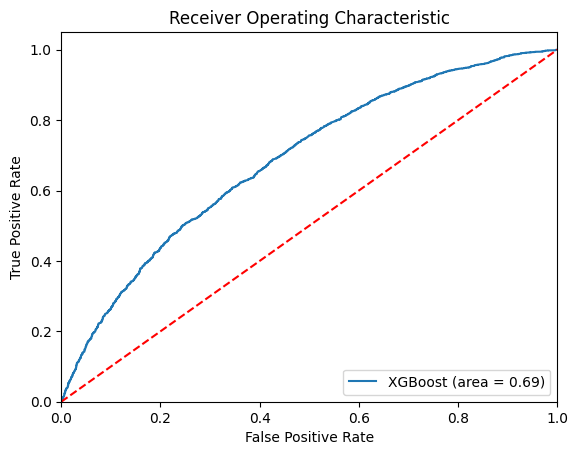

In [ ]:
#XGBoost with Cross-Validation
xgb_model_cv = xgb.XGBClassifier(objective="multi:softmax", num_class=len(set(y)))
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model_cv, X_train, y_train, cv=kfold, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}')
evaluate_model(xgb_model_cv, X_train, y_train, X_test, y_test)


Accuracy on test set: 0.60
Confusion Matrix:
True Neg: 1904 	 False Pos: 1616
False Neg: 1315 	 True Pos: 2456
Precision on test set: 0.60
Recall on test set: 0.65


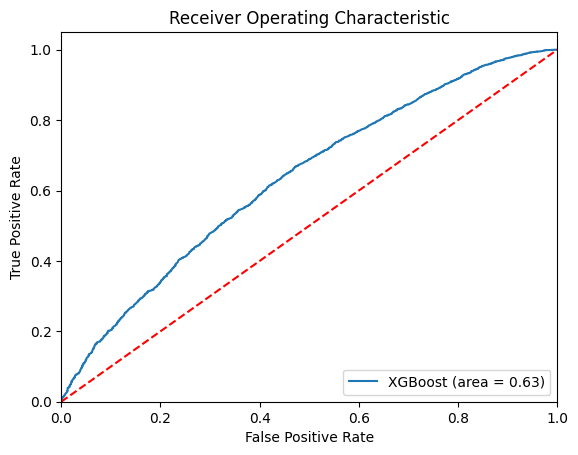

In [ ]:
#XGBoost with Cross-Validation and PCA (using the first 2 principal components)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
xgb_model_pca = xgb.XGBClassifier(objective="multi:softmax", num_class=len(set(y)))
evaluate_model(xgb_model_pca, X_train_pca, y_train, X_test_pca, y_test)


Accuracy on test set: 0.54
Confusion Matrix:
True Neg: 1561 	 False Pos: 1959
False Neg: 1395 	 True Pos: 2376
Precision on test set: 0.55
Recall on test set: 0.63


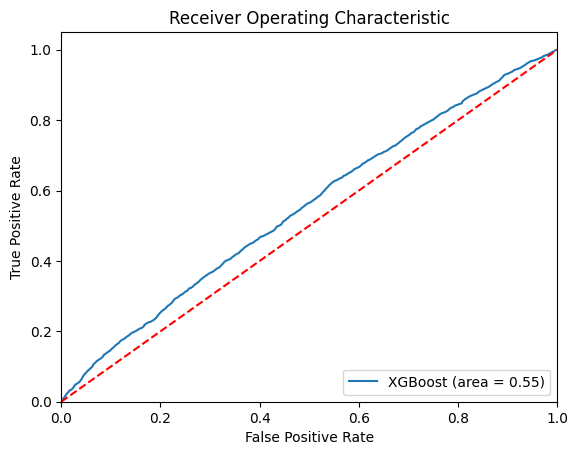

In [ ]:
#XGBoost with Cross-Validation and LDA (assuming LDA factors)
lda = LDA(n_components=3)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
xgb_model_lda = xgb.XGBClassifier(objective="multi:softmax", num_class=len(set(y)))
evaluate_model(xgb_model_lda, X_train_lda, y_train, X_test_lda, y_test)


0:	learn: 0.6913414	total: 32.1ms	remaining: 16s
1:	learn: 0.6896819	total: 71.1ms	remaining: 17.7s
2:	learn: 0.6879397	total: 101ms	remaining: 16.7s
3:	learn: 0.6867341	total: 130ms	remaining: 16.1s
4:	learn: 0.6848220	total: 159ms	remaining: 15.8s
5:	learn: 0.6829262	total: 188ms	remaining: 15.5s
6:	learn: 0.6822712	total: 217ms	remaining: 15.3s
7:	learn: 0.6797802	total: 252ms	remaining: 15.5s
8:	learn: 0.6786334	total: 283ms	remaining: 15.4s
9:	learn: 0.6768672	total: 313ms	remaining: 15.3s
10:	learn: 0.6752493	total: 343ms	remaining: 15.2s
11:	learn: 0.6736035	total: 385ms	remaining: 15.7s
12:	learn: 0.6727973	total: 415ms	remaining: 15.5s
13:	learn: 0.6714954	total: 445ms	remaining: 15.4s
14:	learn: 0.6687455	total: 481ms	remaining: 15.6s
15:	learn: 0.6684426	total: 510ms	remaining: 15.4s
16:	learn: 0.6672335	total: 540ms	remaining: 15.3s
17:	learn: 0.6659391	total: 572ms	remaining: 15.3s
18:	learn: 0.6644792	total: 602ms	remaining: 15.2s
19:	learn: 0.6632792	total: 637ms	remaini

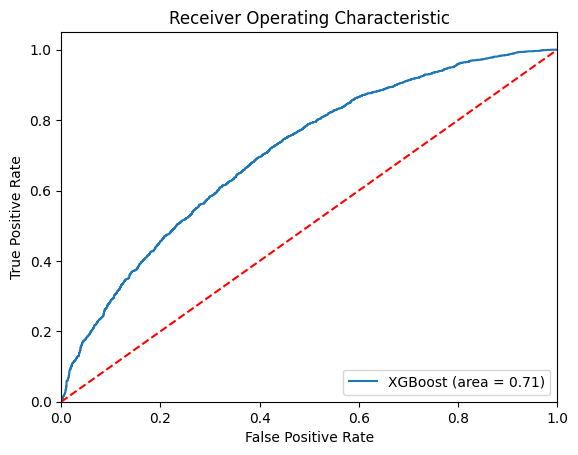

In [ ]:
#Takes very long to run
#XGB Boost, catboost,rf, lgb ensemble with cross fold
# Create individual models
xgb_model = XGBClassifier(learning_rate=0.05, n_estimators=500)
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=10, loss_function='Logloss')
rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=500)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('catboost', catboost_model),
    ('rf', rf_model),
    ('lgb', lgb_model)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

# Define k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store predictions and true labels
predictions = []
true_labels = []

# Perform k-fold cross-validation
for train_idx, test_idx in kfold.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Train the ensemble model on the current fold
    ensemble_model.fit(X_train_fold, y_train_fold)

    # Make predictions on the test set of the current fold
    fold_predictions = ensemble_model.predict(X_test_fold)

    # Append predictions and true labels for evaluation
    predictions.extend(fold_predictions)
    true_labels.extend(y_test_fold)

# Evaluate the model using the defined function
evaluate_model(ensemble_model, X_train, y_train, X_test, y_test)

## KNN

Accuracy on test set: 0.64
Confusion Matrix:
True Neg: 2172 	 False Pos: 1348
False Neg: 1313 	 True Pos: 2458
Precision on test set: 0.65
Recall on test set: 0.65


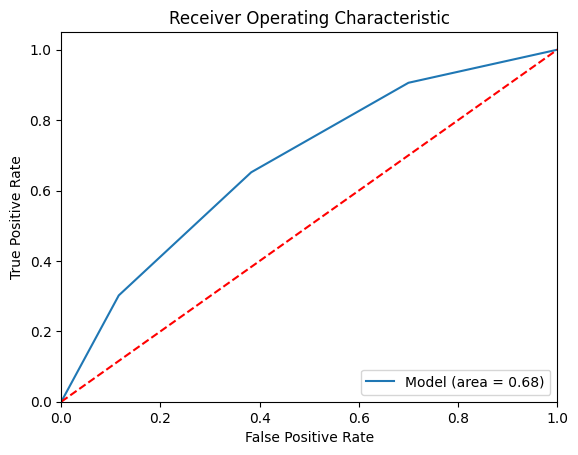

Confusion Matrix:
True Neg: 2172 	 False Pos: 1348
False Neg: 1313 	 True Pos: 2458
Precision of KNN classifier on test set: 0.65
Recall of KNN classifier on test set: 0.65
KNN Accuracy: 0.635029488410369


In [ ]:
#KNN Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# Create and train the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors
knn_model.fit(X_train, y_train)

# Make predictions on the test set
knn_ypred = knn_model.predict(X_test)

# Evaluate the KNN model using the defined function
evaluate_model(knn_model, X_train, y_train, X_test, y_test)


#n = 3 ~ 0.64
#n = 5 ~ 0.63
#n = 7 ~ 0.62

## Neural Network

Accuracy on test set: 0.52
Confusion Matrix:
True Neg: 0 	 False Pos: 3520
False Neg: 0 	 True Pos: 3771
Precision on test set: 0.52
Recall on test set: 1.00


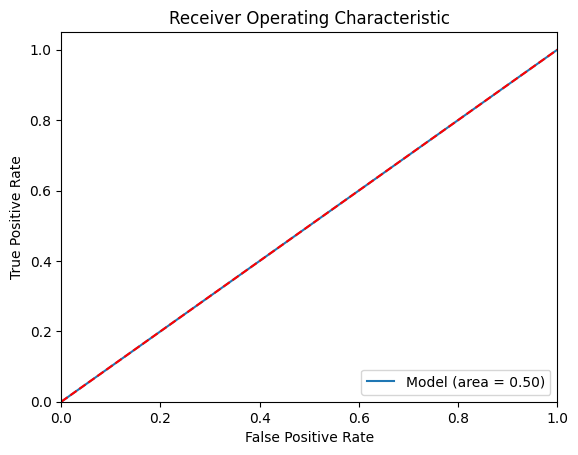

In [ ]:
#Neural Network

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Create and train the Neural Network classifier
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, learning_rate_init=0.001,
                         activation='relu', batch_size=64, alpha=0.001, early_stopping=True, random_state=42)

nn_model.fit(X_train, y_train)
# Make predictions on the test set
nn_ypred = nn_model.predict(X_test)

# Evaluate the Neural Network model using the defined function
evaluate_model(nn_model, X_train, y_train, X_test, y_test)


## Naive Bayes

Accuracy on test set: 0.52
Confusion Matrix:
True Neg: 861 	 False Pos: 2659
False Neg: 824 	 True Pos: 2947
Precision on test set: 0.53
Recall on test set: 0.78


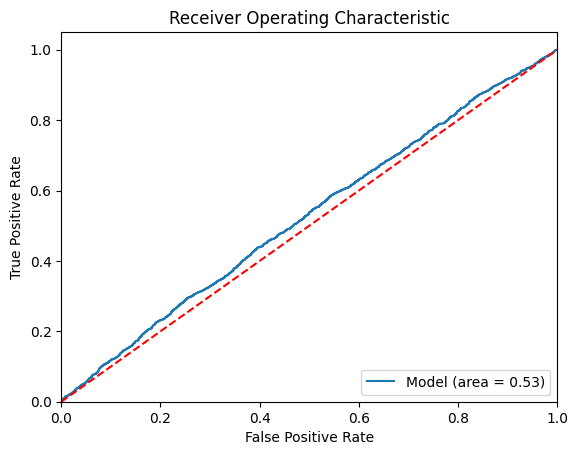

In [ ]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Create and train the Naive Bayes classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions on the test set
nb_ypred = nb_model.predict(X_test)

# Evaluate the Naive Bayes model using the defined function
evaluate_model(nb_model, X_train, y_train, X_test, y_test)


## Gradient Boost

Accuracy on test set: 0.57
Confusion Matrix:
True Neg: 1413 	 False Pos: 2107
False Neg: 1041 	 True Pos: 2730
Precision on test set: 0.56
Recall on test set: 0.72


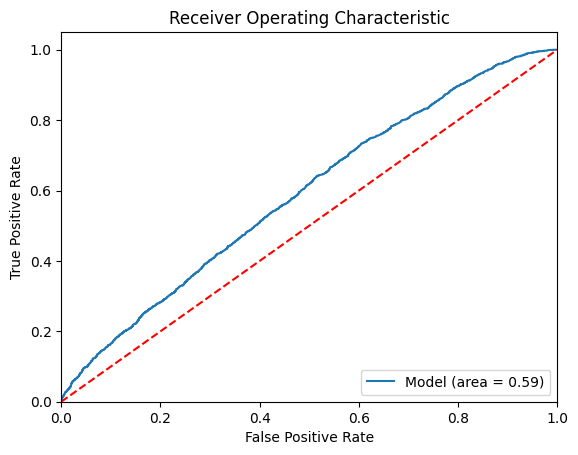

In [ ]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Create and train the Gradient Boosting classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)  # You can adjust parameters
gb_model.fit(X_train, y_train)

# Make predictions on the test set
gb_ypred = gb_model.predict(X_test)

# Evaluate the Gradient Boosting model using the defined function
evaluate_model(gb_model, X_train, y_train, X_test, y_test)

## QDA

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy on test set: 0.51
Confusion Matrix:
True Neg: 1062 	 False Pos: 2458
False Neg: 1092 	 True Pos: 2679
Precision on test set: 0.52
Recall on test set: 0.71


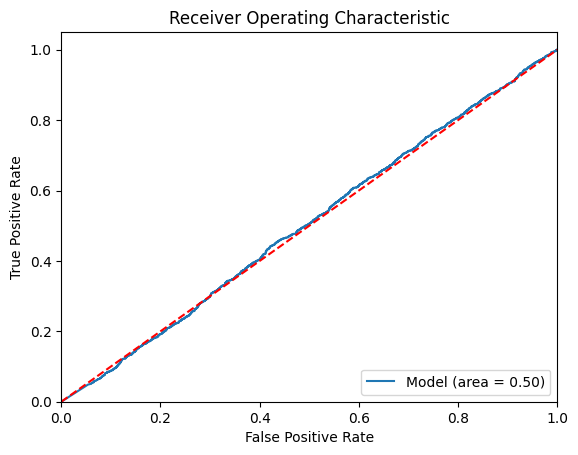

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Create and train the QDA classifier
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)

# Make predictions on the test set
qda_ypred = qda_model.predict(X_test)

# Evaluate the QDA model using the defined function
evaluate_model(qda_model, X_train, y_train, X_test, y_test)
